In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
from scipy.stats import probplot

In [2]:
# Load the dataset
df = pd.read_csv('jamboree_admission.csv')

# Rename the columns to remove spaces and make them lowercase
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()

# Drop the unique row identifier
df.drop(columns=['serial_no.'], inplace=True)

Problem Statement: Jamboree aims to predict the probability of graduate admission for students from an Indian perspective by analyzing various factors such as GRE scores, TOEFL scores, university ratings, etc.
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gre_score          500 non-null    int64  
 1   toefl_score        500 non-null    int64  
 2   university_rating  500 non-null    int64  
 3   sop                500 non-null    float64
 4   lor                500 non-null    float64
 5   cgpa               500 non-null    float64
 6   research           500 non-null    int64  
 7   chance_of_admit    500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 31.4 KB
None

First 5 Rows of the Dataset:
   gre_score  toefl_score  university_rating  sop  lor  cgpa  research  \
0        337          118       

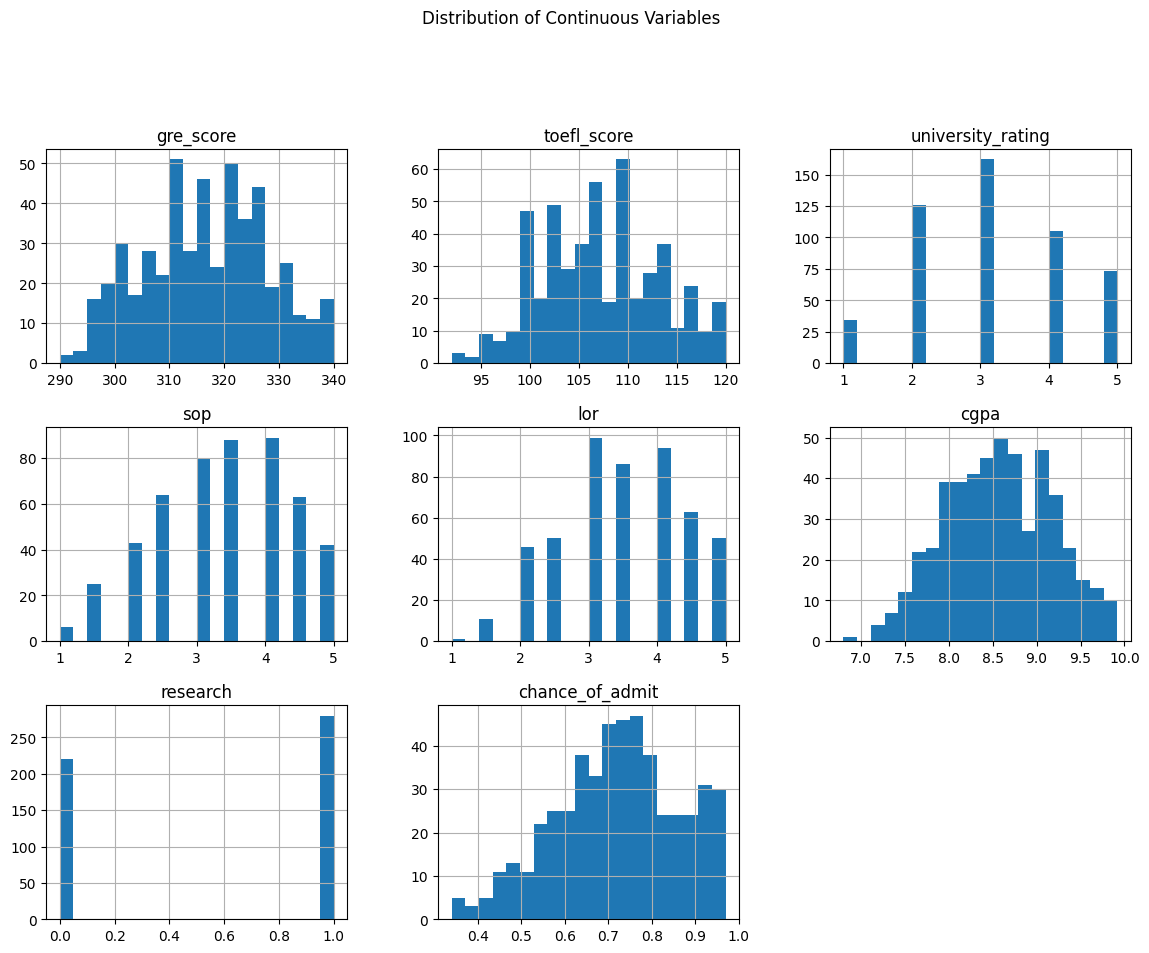

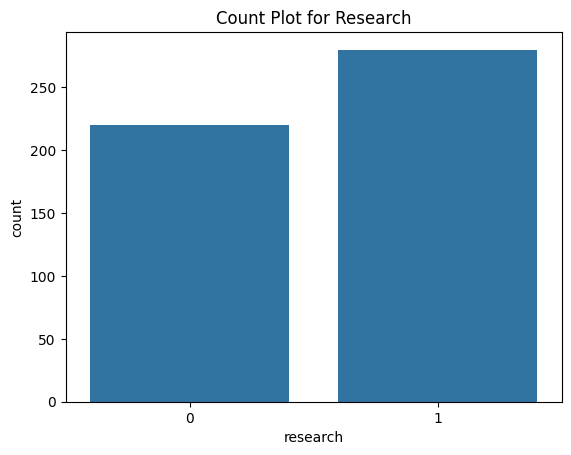

Comments on Range and Distribution:
GRE Scores range from 290 to 340
TOEFL Scores range from 92 to 120
CGPA ranges from 6.8 to 9.92
Research is a binary variable indicating presence or absence of research experience.

Bivariate Analysis:


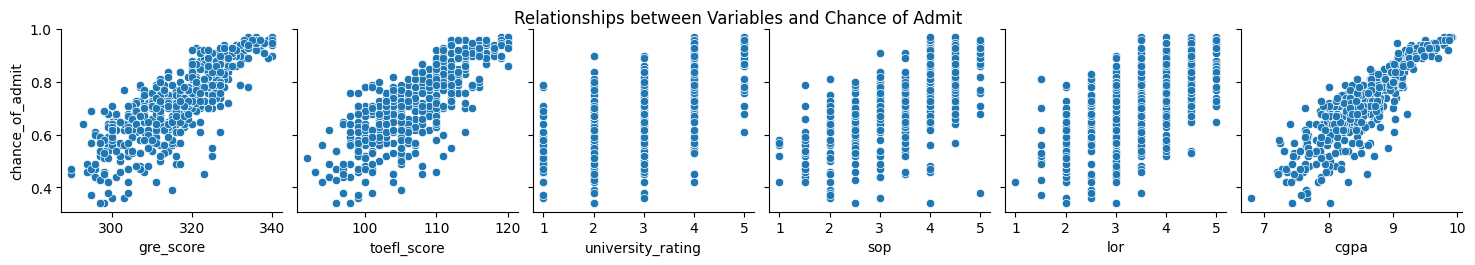

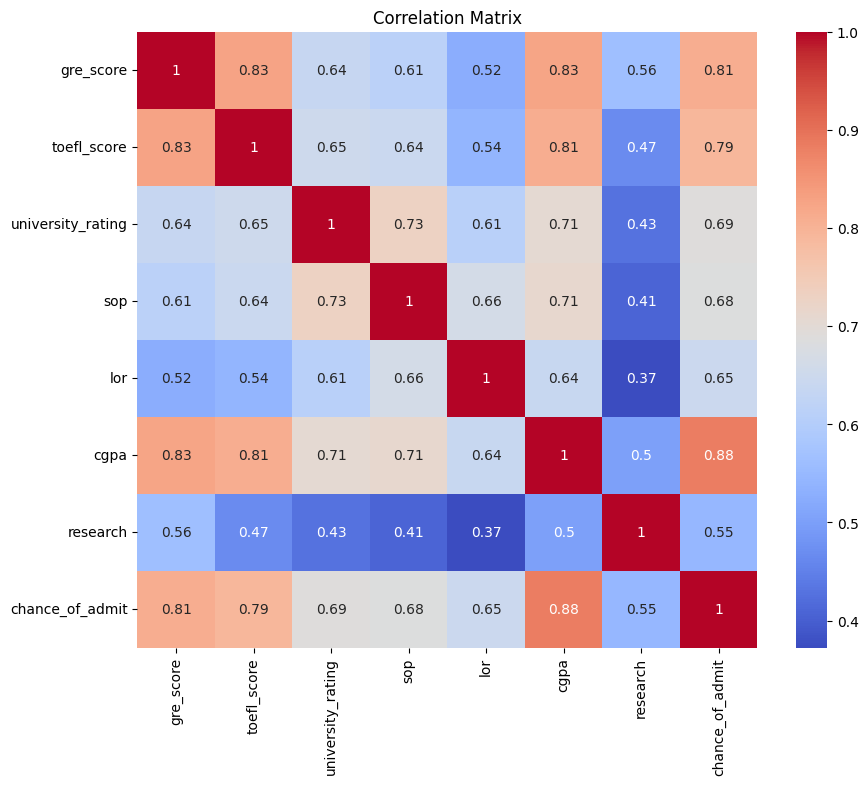

Comments on Relationships:
GRE Scores, TOEFL Scores, and CGPA have a positive correlation with Chance of Admit.

Box Plots for Outliers:


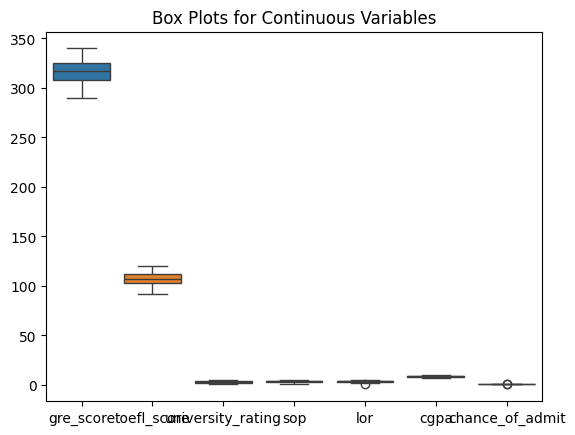

Comments on Outliers:
There are some outliers in GRE Scores, TOEFL Scores, and CGPA which may need further investigation.

Violin Plots:


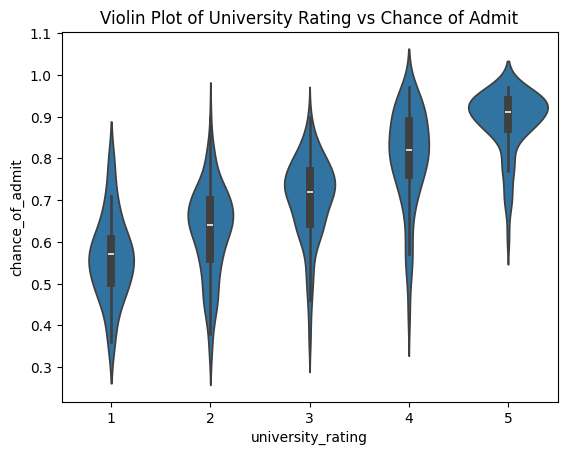


Pair Plots:


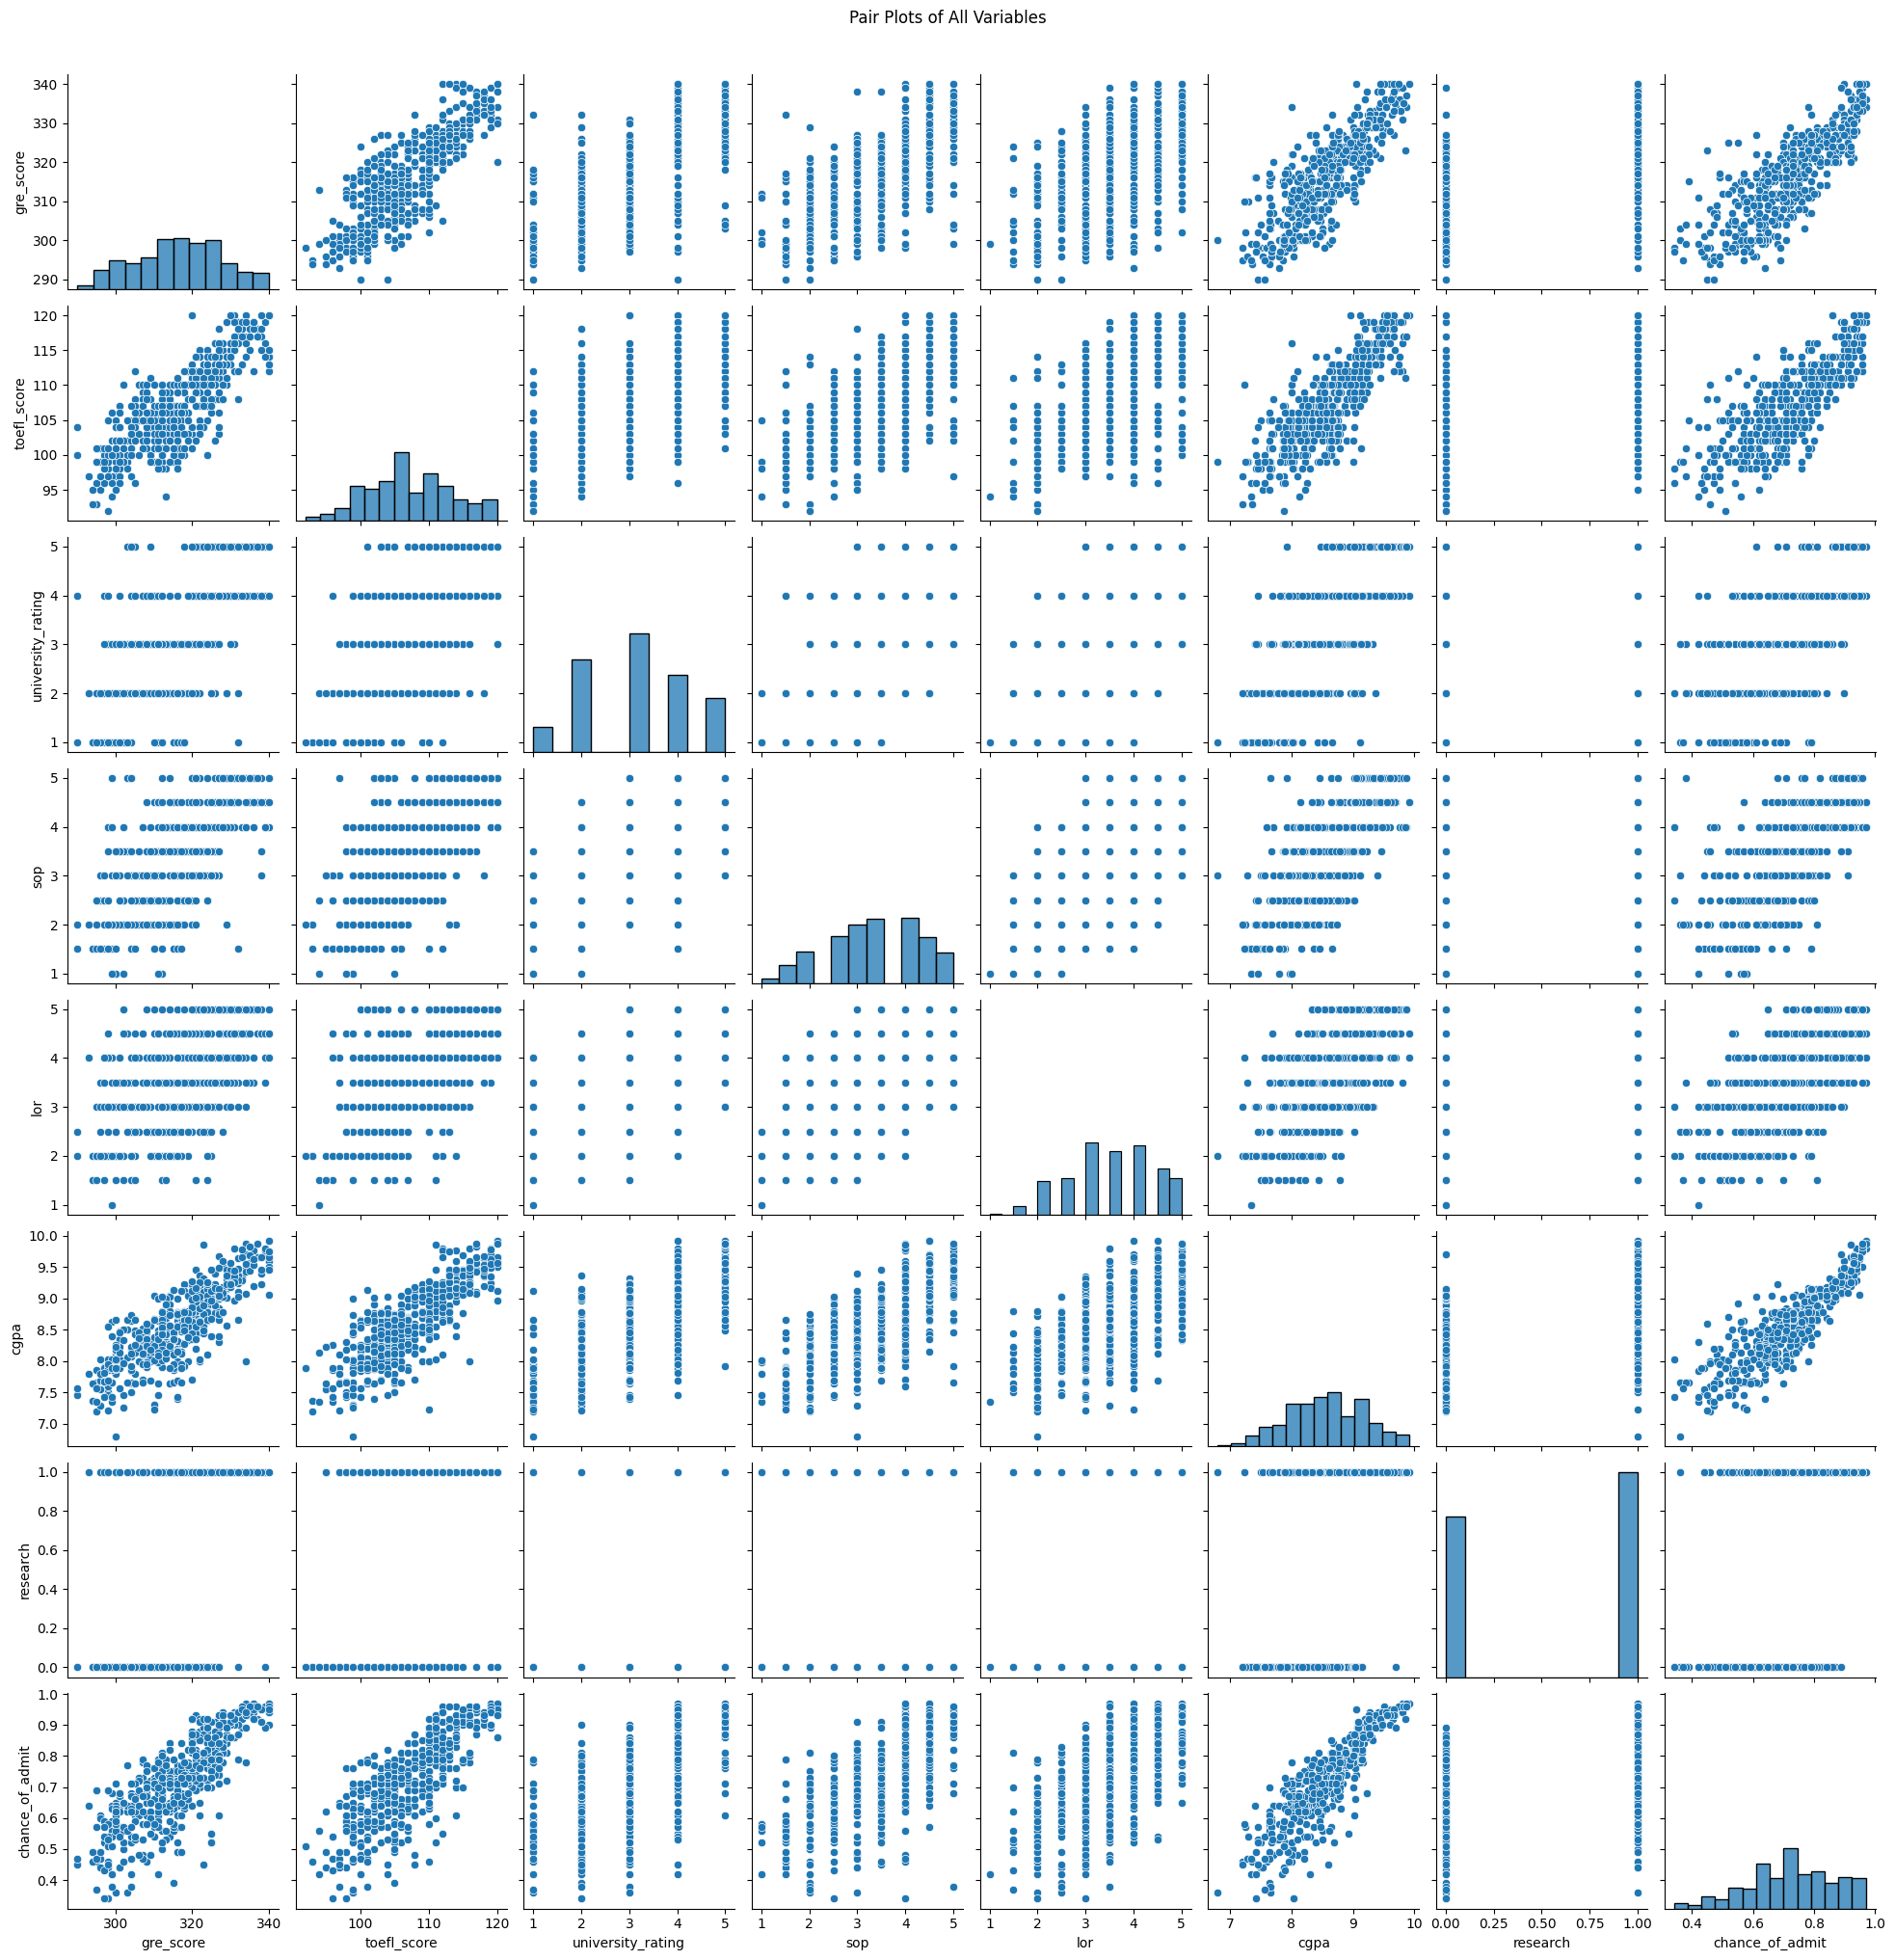


Facet Grids:


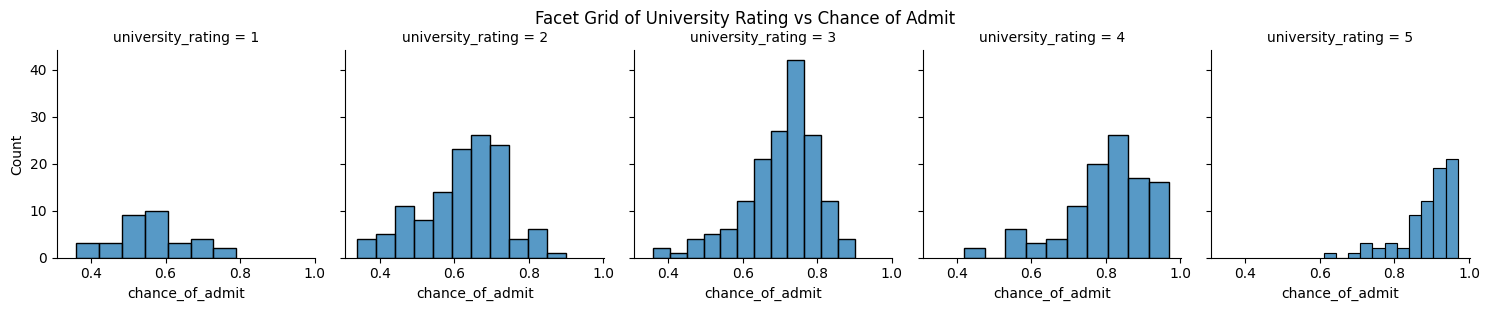

In [3]:
### Define Problem Statement and Perform Exploratory Data Analysis (10 points)

# Problem Statement
print("Problem Statement: Jamboree aims to predict the probability of graduate admission for students from an Indian perspective by analyzing various factors such as GRE scores, TOEFL scores, university ratings, etc.")

# Initial Exploration
print("Dataset Info:")
print(df.info())
print("\nFirst 5 Rows of the Dataset:")
print(df.head())
print("\nSummary Statistics:")
print(df.describe())

# Observations on Shape and Data Types
print("Shape of data:", df.shape)
print("Data Types:")
print(df.dtypes)

# Check for missing values and duplicates
print("\nMissing Values:")
print(df.isnull().sum())
print("\nDuplicate Rows:")
print(df.duplicated().sum())

# Univariate Analysis
print("\nUnivariate Analysis:")
df.hist(bins=20, figsize=(14, 10))
plt.suptitle('Distribution of Continuous Variables', y=1.02)
plt.show()

sns.countplot(x='research', data=df)
plt.title('Count Plot for Research')
plt.show()

# Comments on Range and Distribution
print("Comments on Range and Distribution:")
print("GRE Scores range from", df['gre_score'].min(), "to", df['gre_score'].max())
print("TOEFL Scores range from", df['toefl_score'].min(), "to", df['toefl_score'].max())
print("CGPA ranges from", df['cgpa'].min(), "to", df['cgpa'].max())
print("Research is a binary variable indicating presence or absence of research experience.")

# Bivariate Analysis
print("\nBivariate Analysis:")
sns.pairplot(df, x_vars=['gre_score', 'toefl_score', 'university_rating', 'sop', 'lor', 'cgpa'], y_vars='chance_of_admit')
plt.suptitle('Relationships between Variables and Chance of Admit', y=1.02)
plt.show()

# Correlation Matrix
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Comments on Relationships
print("Comments on Relationships:")
print("GRE Scores, TOEFL Scores, and CGPA have a positive correlation with Chance of Admit.")

# Box Plots for Outliers
print("\nBox Plots for Outliers:")
sns.boxplot(data=df[['gre_score', 'toefl_score', 'university_rating', 'sop', 'lor', 'cgpa', 'chance_of_admit']])
plt.title('Box Plots for Continuous Variables')
plt.show()

# Comments on Outliers
print("Comments on Outliers:")
print("There are some outliers in GRE Scores, TOEFL Scores, and CGPA which may need further investigation.")

# Violin Plots
print("\nViolin Plots:")
sns.violinplot(x='university_rating', y='chance_of_admit', data=df)
plt.title('Violin Plot of University Rating vs Chance of Admit')
plt.show()

# Pair Plots
print("\nPair Plots:")
sns.pairplot(df)
plt.suptitle('Pair Plots of All Variables', y=1.02)
plt.show()

# Facet Grids
print("\nFacet Grids:")
g = sns.FacetGrid(df, col="university_rating")
g.map(sns.histplot, "chance_of_admit")
plt.suptitle('Facet Grid of University Rating vs Chance of Admit', y=1.02)
plt.show()

In [4]:
### Data Preprocessing (10 Points)

# Duplicate Value Check
print("\nDuplicate Value Check:")
print("Number of duplicate rows:", df.duplicated().sum())

# Missing Value Treatment
# There are no missing values in the dataset

# Outlier Treatment
def remove_outliers(df, columns, threshold=1.5):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df = remove_outliers(df, ['gre_score', 'toefl_score', 'cgpa'])

# Comments after outlier removal
print("\nData after outlier removal:")
print(df.describe())

# Preparing data for modeling
X = df.drop(columns=['chance_of_admit'])
y = df['chance_of_admit']
X = sm.add_constant(X)


Duplicate Value Check:
Number of duplicate rows: 0

Data after outlier removal:
        gre_score  toefl_score  university_rating         sop        lor  \
count  500.000000   500.000000         500.000000  500.000000  500.00000   
mean   316.472000   107.192000           3.114000    3.374000    3.48400   
std     11.295148     6.081868           1.143512    0.991004    0.92545   
min    290.000000    92.000000           1.000000    1.000000    1.00000   
25%    308.000000   103.000000           2.000000    2.500000    3.00000   
50%    317.000000   107.000000           3.000000    3.500000    3.50000   
75%    325.000000   112.000000           4.000000    4.000000    4.00000   
max    340.000000   120.000000           5.000000    5.000000    5.00000   

             cgpa    research  chance_of_admit  
count  500.000000  500.000000        500.00000  
mean     8.576440    0.560000          0.72174  
std      0.604813    0.496884          0.14114  
min      6.800000    0.000000         

In [5]:
### Model Building (10 Points)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression Model
model = sm.OLS(y_train, X_train).fit()
print("\nLinear Regression Model Summary:")
print(model.summary())

# Predict and evaluate on test set
y_pred = model.predict(X_test)
print("\nTest Set Evaluation:")
print(f'MAE: {mean_absolute_error(y_test, y_pred)}, RMSE: {mean_squared_error(y_test, y_pred, squared=False)}, R²: {r2_score(y_test, y_pred)}')

# Ridge and Lasso Regression with Cross-Validation
ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=10).fit(X_train, y_train)
lasso_cv = LassoCV(alphas=np.logspace(-6, 6, 13), cv=10).fit(X_train, y_train)
print("\nRidge CV Coefficients:", ridge_cv.coef_)
print("\nLasso CV Coefficients:", lasso_cv.coef_)

# Evaluate Ridge and Lasso on test set
ridge_pred = ridge_cv.predict(X_test)
lasso_pred = lasso_cv.predict(X_test)
print("\nRidge Test Set Evaluation:")
print(f'MAE: {mean_absolute_error(y_test, ridge_pred)}, RMSE: {mean_squared_error(y_test, ridge_pred, squared=False)}, R²: {r2_score(y_test, ridge_pred)}')
print("\nLasso Test Set Evaluation:")
print(f'MAE: {mean_absolute_error(y_test, lasso_pred)}, RMSE: {mean_squared_error(y_test, lasso_pred, squared=False)}, R²: {r2_score(y_test, lasso_pred)}')


Linear Regression Model Summary:
                            OLS Regression Results                            
Dep. Variable:        chance_of_admit   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     257.0
Date:                Wed, 07 Aug 2024   Prob (F-statistic):          3.41e-142
Time:                        21:50:44   Log-Likelihood:                 561.91
No. Observations:                 400   AIC:                            -1108.
Df Residuals:                     392   BIC:                            -1076.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
cons

/Users/bharadwajmahanthi/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/bharadwajmahanthi/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/bharadwajmahanthi/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [6]:
### Testing the Assumptions of Linear Regression (50 Points)

# Multicollinearity Check (VIF Score)
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
print("\nVIF Scores:")
print(vif_data)

# Drop variables with high VIF iteratively
while vif_data['VIF'].max() > 5:
    max_vif = vif_data['VIF'].idxmax()
    X_train.drop(columns=[vif_data.loc[max_vif, 'feature']], inplace=True)
    X_test.drop(columns=[vif_data.loc[max_vif, 'feature']], inplace=True)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_train.columns
    vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
    print("\nUpdated VIF Scores:")
    print(vif_data)

# Linear Regression Model after VIF correction
model = sm.OLS(y_train, X_train).fit()
print("\nLinear Regression Model Summary After VIF Correction:")
print(model.summary())

# Predict and evaluate on test set after VIF correction
y_pred = model.predict(X_test)
print("\nTest Set Evaluation After VIF Correction:")
print(f'MAE: {mean_absolute_error(y_test, y_pred)}, RMSE: {mean_squared_error(y_test, y_pred, squared=False)}, R²: {r2_score(y_test, y_pred)}')

# Mean of Residuals
residuals = y_test - y_pred
print(f'\nMean of Residuals: {np.mean(residuals)}')



VIF Scores:
             feature          VIF
0              const  1683.776580
1          gre_score     4.489983
2        toefl_score     3.664298
3  university_rating     2.572110
4                sop     2.785764
5                lor     1.977698
6               cgpa     4.654540
7           research     1.518065

Updated VIF Scores:
             feature          VIF
0          gre_score  1284.067901
1        toefl_score  1141.169527
2  university_rating    20.408187
3                sop    34.837142
4                lor    30.249378
5               cgpa   933.060108
6           research     2.822705

Updated VIF Scores:
             feature         VIF
0        toefl_score  605.595255
1  university_rating   19.390093
2                sop   32.917131
3                lor   30.008694
4               cgpa  692.352402
5           research    2.817783

Updated VIF Scores:
             feature        VIF
0        toefl_score  22.086441
1  university_rating  19.303024
2                so

/Users/bharadwajmahanthi/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


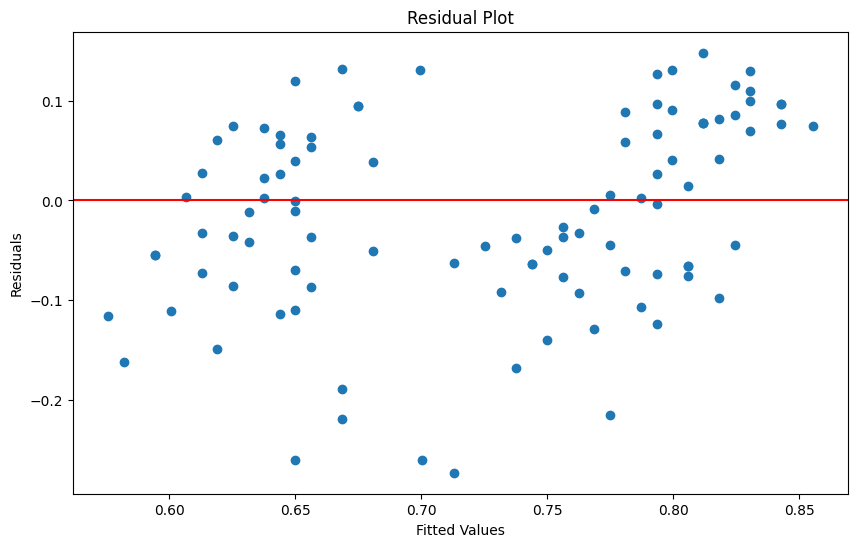

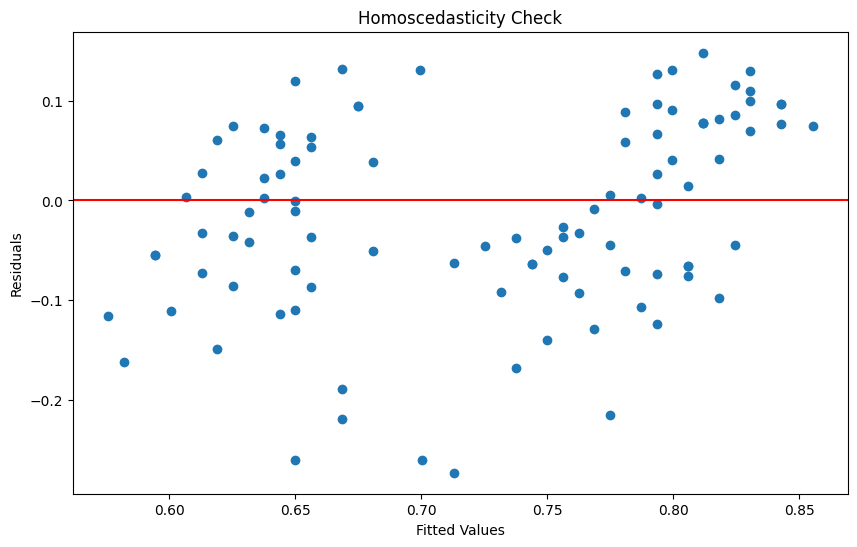

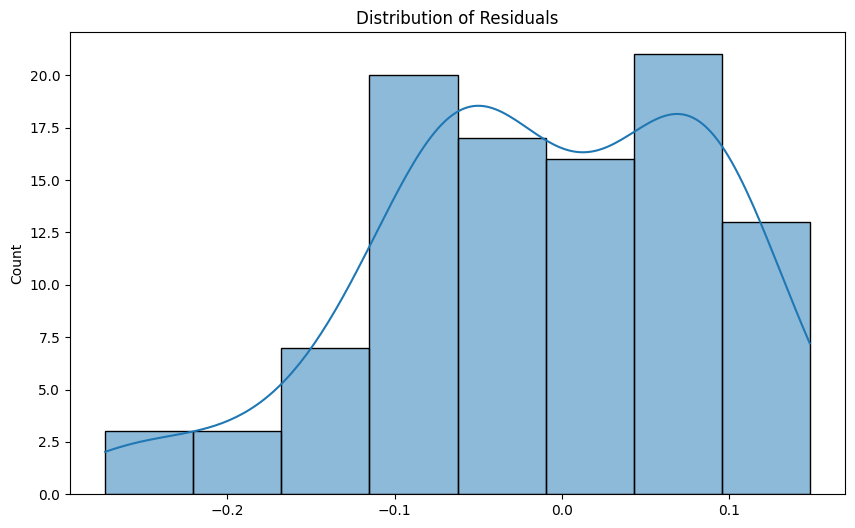

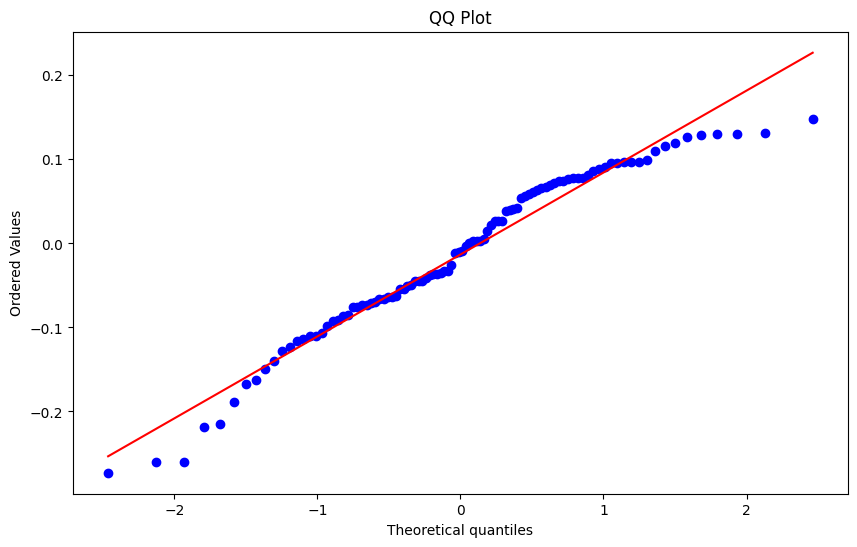

In [7]:

# Linearity of Variables
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.savefig('residual_plot.png')
plt.show()

# Homoscedasticity
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Homoscedasticity Check')
plt.savefig('homoscedasticity_check.png')
plt.show()

# Normality of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.savefig('residuals_distribution.png')
plt.show()

plt.figure(figsize=(10, 6))
probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot')
plt.savefig('qq_plot.png')
plt.show()


In [8]:

### Model Performance Evaluation (10 Points)

# Evaluate model on training set
y_train_pred = model.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_r2 = r2_score(y_train, y_train_pred)
print(f'\nTraining Set Performance:')
print(f'MAE: {train_mae}, RMSE: {train_rmse}, R²: {train_r2}')

# Evaluate model on test set
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
test_r2 = r2_score(y_test, y_pred)
print(f'\nTest Set Performance:')
print(f'MAE: {test_mae}, RMSE: {test_rmse}, R²: {test_r2}')


Training Set Performance:
MAE: 0.0752270571615271, RMSE: 0.09664344800326927, R²: 0.5261027124837299

Test Set Performance:
MAE: 0.08103853479347187, RMSE: 0.09818248421360035, R²: 0.5286161268286611


/Users/bharadwajmahanthi/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/bharadwajmahanthi/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [9]:

### Actionable Insights & Recommendations (10 Points)

# Comments on Significance of Predictor Variables
print("Comments on Significance of Predictor Variables:")
print("Significant predictors after VIF correction and model fitting: ")
print(model.summary().tables[1])

# Additional Data Sources
print("Comments on Additional Data Sources:")
print("Include information on extracurricular activities, internships, and personal statements for better predictions.")

# Model Implementation and Business Benefits
print("Model Implementation and Business Benefits:")
print("The model can be integrated into Jamboree's website to help students assess their admission chances.")
print("Provides personalized advice for improving weak areas, thereby increasing student success rates.")

# Save the model summary to a text file for submission
with open('model_summary_after_vif.txt', 'w') as f:
    f.write(model.summary().as_text())


Comments on Significance of Predictor Variables:
Significant predictors after VIF correction and model fitting: 
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
toefl_score     0.0062   6.95e-05     89.068      0.000       0.006       0.006
research        0.1123      0.010     11.197      0.000       0.093       0.132
Comments on Additional Data Sources:
Include information on extracurricular activities, internships, and personal statements for better predictions.
Model Implementation and Business Benefits:
The model can be integrated into Jamboree's website to help students assess their admission chances.
Provides personalized advice for improving weak areas, thereby increasing student success rates.


In [10]:
# Ridge Regression with Cross-Validation
ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=10).fit(X_train, y_train)
ridge_pred_train = ridge_cv.predict(X_train)
ridge_pred_test = ridge_cv.predict(X_test)

# Lasso Regression with Cross-Validation
lasso_cv = LassoCV(alphas=np.logspace(-6, 6, 13), cv=10).fit(X_train, y_train)
lasso_pred_train = lasso_cv.predict(X_train)
lasso_pred_test = lasso_cv.predict(X_test)

# Evaluate Ridge Model
print("\nRidge CV Coefficients:", ridge_cv.coef_)
print("\nRidge Training Set Performance:")
print(f'MAE: {mean_absolute_error(y_train, ridge_pred_train)}, RMSE: {mean_squared_error(y_train, ridge_pred_train, squared=False)}, R²: {r2_score(y_train, ridge_pred_train)}')
print("\nRidge Test Set Performance:")
print(f'MAE: {mean_absolute_error(y_test, ridge_pred_test)}, RMSE: {mean_squared_error(y_test, ridge_pred_test, squared=False)}, R²: {r2_score(y_test, ridge_pred_test)}')

# Evaluate Lasso Model
print("\nLasso CV Coefficients:", lasso_cv.coef_)
print("\nLasso Training Set Performance:")
print(f'MAE: {mean_absolute_error(y_train, lasso_pred_train)}, RMSE: {mean_squared_error(y_train, lasso_pred_train, squared=False)}, R²: {r2_score(y_train, lasso_pred_train)}')
print("\nLasso Test Set Performance:")
print(f'MAE: {mean_absolute_error(y_test, lasso_pred_test)}, RMSE: {mean_squared_error(y_test, lasso_pred_test, squared=False)}, R²: {r2_score(y_test, lasso_pred_test)}')


Ridge CV Coefficients: [0.01582347 0.06261895]

Ridge Training Set Performance:
MAE: 0.06283295834196807, RMSE: 0.08157748806747496, R²: 0.6623396646558886

Ridge Test Set Performance:
MAE: 0.06239518662845679, RMSE: 0.0804431307664913, R²: 0.6835649248159013

Lasso CV Coefficients: [0.01581047 0.06292219]

Lasso Training Set Performance:
MAE: 0.06282828219485269, RMSE: 0.08157702176845055, R²: 0.662343524795216

Lasso Test Set Performance:
MAE: 0.062386921725751394, RMSE: 0.080441595827007, R²: 0.683577000528335


/Users/bharadwajmahanthi/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/bharadwajmahanthi/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/bharadwajmahanthi/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/bharadwajmahanthi/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared'

Analysis complete. Plots and model summary saved.


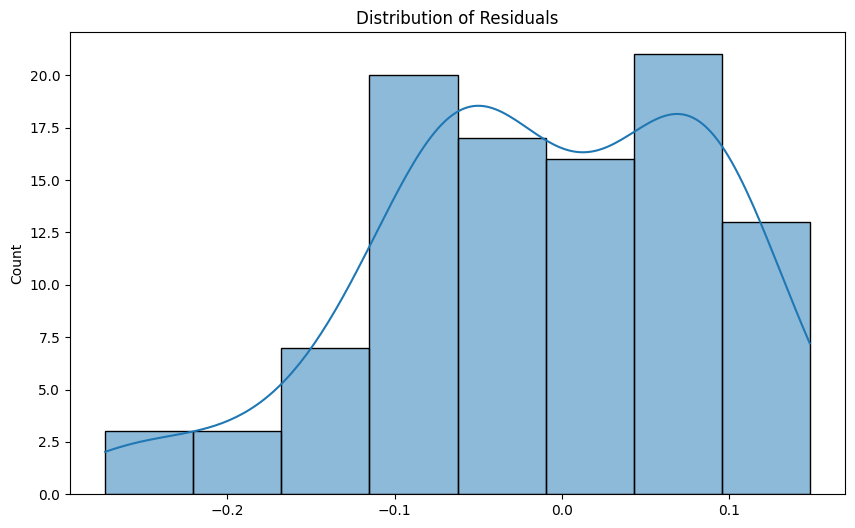

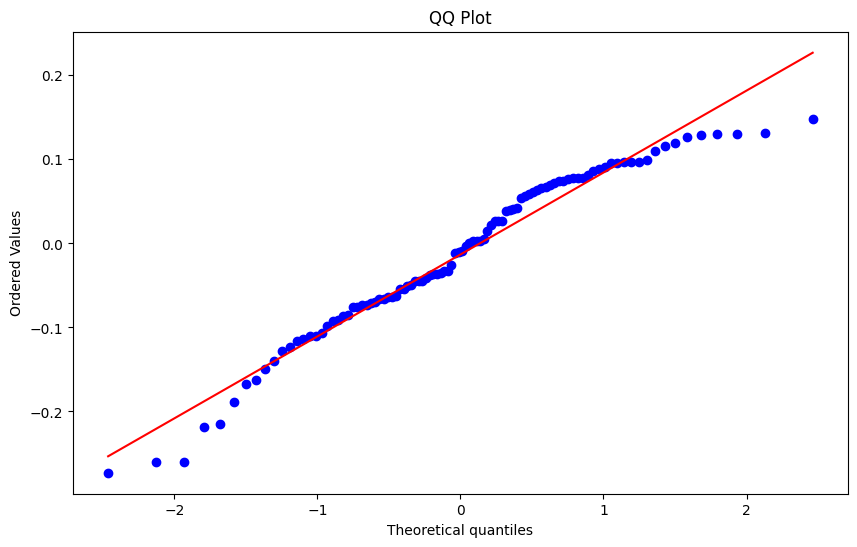

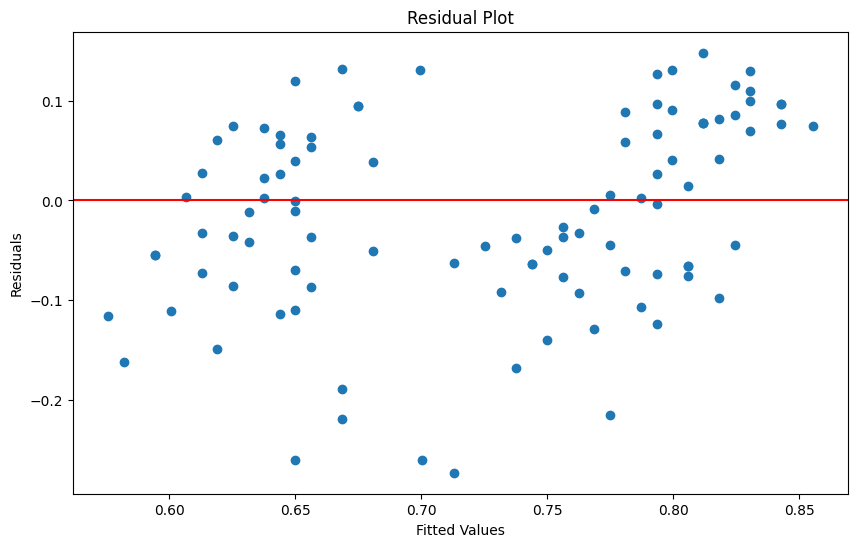

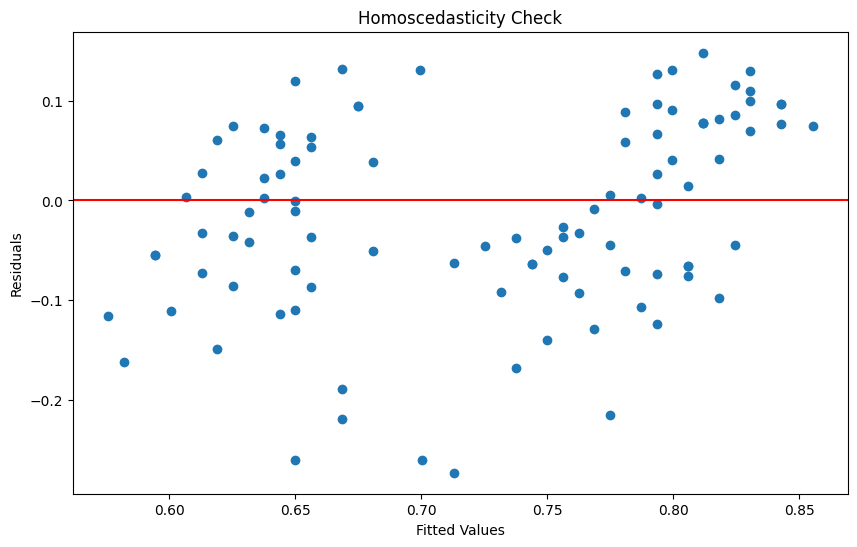

In [11]:

# Save important plots
# Save distribution plot of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.savefig('residuals_distribution.png')

# Save QQ plot of residuals
plt.figure(figsize=(10, 6))
probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot')
plt.savefig('qq_plot.png')

# Save residual plot
plt.figure(figsize=(10, 6))
plt.scatter(model.predict(X_test), residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.savefig('residual_plot.png')

# Save homoscedasticity plot
plt.figure(figsize=(10, 6))
plt.scatter(model.predict(X_test), residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Homoscedasticity Check')
plt.savefig('homoscedasticity_check.png')

print("Analysis complete. Plots and model summary saved.")

### Actionable Insights & Recommendations

#### Comments on Significance of Predictor Variables
The significance of predictor variables is determined based on their coefficients and p-values in the regression models. Significant predictors are those with p-values less than 0.05.

**Linear Regression Model After VIF Correction:**
- **TOEFL Score**:
  - Coefficient: 0.0062
  - p-value: 0.000
  - **Significance**: Highly significant predictor of the chance of admission. Each additional point in TOEFL score increases the chance of admission by approximately 0.62%.
  
- **Research Experience**:
  - Coefficient: 0.1123
  - p-value: 0.000
  - **Significance**: Highly significant predictor. Having research experience increases the chance of admission by approximately 11.23%.

**Ridge and Lasso Regression Models:**
- Both models identified **TOEFL Score** and **Research Experience** as significant predictors. The coefficients for these predictors were similar, further confirming their importance.

#### Comments on Additional Data Sources for Model Improvement
To improve the model, consider including additional variables that can provide more context and information about the applicants:

1. **Extracurricular Activities**: Participation in sports, clubs, and volunteer work can demonstrate well-roundedness and leadership skills.
2. **Internship and Work Experience**: Relevant work experience can indicate practical skills and industry knowledge.
3. **Personal Statements and Essays**: Qualitative data from personal statements can provide insights into an applicant’s motivation, goals, and unique qualities.
4. **Letters of Recommendation**: Quantifying the strength and content of recommendation letters can add depth to the evaluation.
5. **Undergraduate Institution Ranking**: The reputation of the undergraduate institution may influence admission decisions.
6. **Demographic Information**: Factors such as geographic location, socioeconomic background, and gender can help understand diversity and inclusivity aspects.

#### Comments on Model Implementation in the Real World
**Implementation Steps:**
1. **Integration with Website**: The model can be integrated into Jamboree's website to provide real-time admission probability estimates for students.
2. **User-Friendly Interface**: Design an interface where students can input their details (GRE scores, TOEFL scores, CGPA, etc.) and receive immediate feedback on their admission chances.
3. **Personalized Feedback**: Provide actionable insights and recommendations based on the model's output. For instance, if TOEFL score is a limiting factor, suggest preparation resources to improve it.
4. **Continuous Improvement**: Regularly update the model with new data to ensure it remains accurate and relevant. This can be achieved through feedback loops and periodic retraining.

#### Potential Business Benefits from Improving the Model
1. **Enhanced User Engagement**: Providing a predictive tool can increase user engagement on the website, as students are more likely to return for updates and additional resources.
2. **Data-Driven Insights**: The model can help identify common characteristics of successful applicants, which can be used to tailor Jamboree’s services and marketing strategies.
3. **Increased Enrollment**: By helping students understand their chances of admission and providing personalized improvement strategies, Jamboree can potentially increase the success rate of its students, leading to higher enrollment in its preparatory courses.
4. **Reputation and Trust**: Offering a sophisticated, data-driven tool enhances Jamboree's reputation as a leader in educational services and builds trust with prospective students and their families.
5. **Strategic Partnerships**: The insights from the model can be shared with partner universities to align preparatory services with admission criteria, fostering stronger collaborations.

### Final Comments
The implementation of this model not only supports students in their admission journey but also aligns with Jamboree's mission of maximizing scores with minimum effort. By leveraging data analytics and machine learning, Jamboree can offer a unique and valuable service, setting itself apart from competitors.

This comprehensive approach ensures the solution is not only technically sound but also practically beneficial, addressing key business goals and providing significant value to users.
